## Bernoulli VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Bernoulli base distribution with Logit Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

We run each scenario 100 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.089504658
 0.090575198
 0.104667413
 0.130849897
 0.119530977
 0.119245044
 0.174908457
 0.149012324
 0.173845657
 0.102049783
 0.094210366
 0.184713357
 0.157191159
 ⋮
 7.066568967
 8.89619971
 8.929004183
 8.355083312
 8.313687096
 8.170997987
 6.776775029
 8.156323865
 7.42781396
 7.049692122
 8.819699854
 6.263928285

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  1.331191769
  0.019016142
  0.019641954
  0.016183717
  0.014963535
  0.015947859
  0.013046647
  0.018384432
  0.019989725
  0.016649082
  0.015243163
  0.015576509
  0.015094806
  ⋮
 16.921534472
 16.419947767
 14.445486372
 14.95120825
 14.462124505
 15.705583124
 14.954172799
 15.47089841
 15.210482544
 16.160363916
 16.467763369
 16.188561692

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.130626,0.00308919,200,0.127537,0.136805,0.000653132
2,100,5,0.204913,0.0159226,500,0.188991,0.236758,0.000409826
3,100,10,0.133971,0.00588678,1000,0.128084,0.145744,0.000133971
4,100,15,0.161838,0.0124331,1500,0.149405,0.186704,0.000107892
5,100,20,0.154424,0.00754533,2000,0.146879,0.169515,7.72121e-5
6,100,25,0.154979,0.00418604,2500,0.150793,0.163351,6.19915e-5
7,1000,2,0.255017,0.00490087,2000,0.250116,0.264819,0.000127509
8,1000,5,0.329882,0.0110095,5000,0.318872,0.351901,6.59763e-5
9,1000,10,0.367006,0.00598368,10000,0.361023,0.378974,3.67006e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0305513,0.0131837,200,0.0173676,0.043735,0.000152756
2,100,5,0.0596983,0.0058009,500,0.0538974,0.0654992,0.000119397
3,100,10,0.0610629,0.00325953,1000,0.0578034,0.0643224,6.10629e-5
4,100,15,0.109523,0.0098798,1500,0.099643,0.119403,7.30152e-5
5,100,20,0.122802,0.00603475,2000,0.116767,0.128837,6.14009e-5
6,100,25,0.151673,0.00412923,2500,0.147544,0.155802,6.06692e-5
7,1000,2,0.166529,0.00291205,2000,0.163617,0.169441,8.32645e-5
8,1000,5,0.356314,0.010374,5000,0.34594,0.366689,7.12629e-5
9,1000,10,0.670367,0.0103249,10000,0.660042,0.680692,6.70367e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


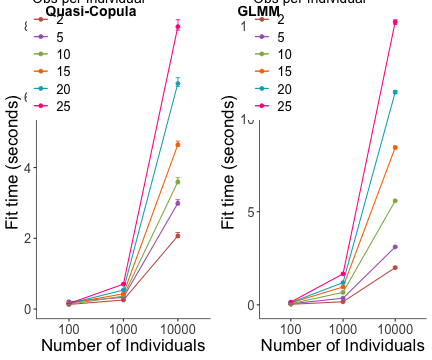

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
ggsave('fittime_nsamples_logistic_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_logistic_vs_glmm.png"


In [9]:
# using RCall
# @rput timedf1
# @rput timedf2

# R"""
# library(scales)
# library(ggplot2)
# timedf1$obssize <- factor(timedf1$obssize, levels = c('2', '5', '10', '20', '50'))
# timedf1$samplesize <- factor(timedf1$samplesize, levels = c('1000', '10000', '100000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs1 = ggplot(timedf1, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

# # glmm fit times
# timedf2$obssize <- factor(timedf2$obssize, levels = c('2', '5', '10', '20', '50'))
# timedf2$samplesize <- factor(timedf2$samplesize, levels = c('1000', '10000', '100000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs2 = ggplot(timedf2, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

# fittime_perobs = plot_grid(fittimeperobs1, fittimeperobs2, labels = c("Quasi-Copula", "GLMM"))

# """

# R"""
# ggsave('fittime_perobs_poisson_vs_glmm.png', fittime_perobs, width = 12.5, height = 15, units = 'in', dpi = 450)
# """

In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_multivariate_logistic_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.87, 0.0337998)","(0.59, 0.0494311)","(0.66, 0.0476095)","(0.91, 0.0287623)"
2,N: 100 ni: 5,"(0.73, 0.0446196)","(0.41, 0.0494311)","(0.61, 0.0490207)","(0.9, 0.0301511)"
3,N: 100 ni: 10,"(0.57, 0.049757)","(0.24, 0.0429235)","(0.45, 0.05)","(0.92, 0.027266)"
4,N: 100 ni: 15,"(0.36, 0.0482418)","(0.05, 0.0219043)","(0.39, 0.0490207)","(0.92, 0.027266)"
5,N: 100 ni: 20,"(0.22, 0.0416333)","(0.03, 0.0171447)","(0.3, 0.0460566)","(0.89, 0.0314466)"
6,N: 100 ni: 25,"(0.15, 0.035887)","(0.0, 0.0)","(0.45, 0.05)","(0.94, 0.0238683)"
7,N: 1000 ni: 2,"(0.61, 0.0490207)","(0.29, 0.0456048)","(0.21, 0.040936)","(0.93, 0.0256432)"
8,N: 1000 ni: 5,"(0.38, 0.0487832)","(0.01, 0.01)","(0.04, 0.0196946)","(0.98, 0.0140705)"
9,N: 1000 ni: 10,"(0.02, 0.0140705)","(0.0, 0.0)","(0.0, 0.0)","(0.89, 0.0314466)"


In [13]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresultpoisson = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

βMseresultpoisson_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresultpoisson, Σmse = ΣMseresultpoisson, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresultpoisson_GLMM, Σmse = ΣMseresultpoisson_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Bernoulli Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Bernoulli GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.269507,2,100,beta,Bernoulli Quasi-Copula
2,0.132675,2,100,beta,Bernoulli Quasi-Copula
3,0.14261,2,100,beta,Bernoulli Quasi-Copula
4,0.0989447,2,100,beta,Bernoulli Quasi-Copula
5,0.00854191,2,100,beta,Bernoulli Quasi-Copula
6,0.238617,2,100,beta,Bernoulli Quasi-Copula
7,0.0137437,2,100,beta,Bernoulli Quasi-Copula
8,0.05547,2,100,beta,Bernoulli Quasi-Copula
9,0.245224,2,100,beta,Bernoulli Quasi-Copula


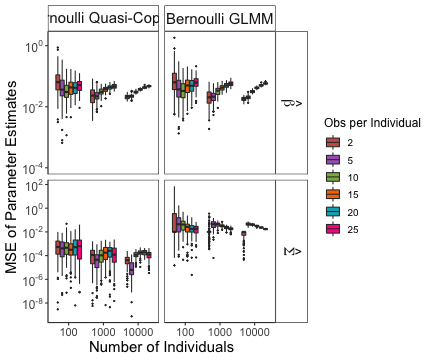

RObject{VecSxp}


In [16]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Bernoulli Quasi-Copula', 'Bernoulli GLMM'),
    labels = c(expression(paste("Bernoulli Quasi-Copula")), expression(paste("Bernoulli GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [17]:
R"""
ggsave('updated_msefacetplot_bernoulli.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_bernoulli.png"
